In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import skimage
import toml
import glob
import pyarrow as pa
import pandas as pd
import sleap_io as sio
import warnings

from segments import SegmentsClient
from tqdm.auto import tqdm
from markovids import vid, pcl
from scipy.spatial.distance import pdist
from joblib import Parallel, delayed
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error

In [4]:
def get_l2_norm(df, x1="kpoint_x", x2="kpoint_com_gauss_x", y1="kpoint_y", y2="kpoint_com_gauss_y"):
    return np.linalg.norm([df[x1] - df[x2], df[y1] - df[y2]])

In [5]:
def get_l2_norm_diffs(df, x="kpoint_use_x", y="kpoint_use_y"):
    return np.linalg.norm([df[x],df[y]])

In [6]:
# TRY KPOINT X/Y HERE
def convert_to_point_array(df, x_key="kpoint_use_x", y_key="kpoint_use_y", n_nodes=10):
    # sort by kpoint num
    assert len(df) == df["kpoint_name"].nunique()
    new_array = np.full((n_nodes, 2), fill_value=np.nan)
    for _idx, _row in df.iterrows():
        new_array[int(_row["kpoint_idx"]), 0] = _row[x_key]
        new_array[int(_row["kpoint_idx"]), 1] = _row[y_key]
    return new_array

In [7]:
def tail_filter(df):
    # cond1 = (df["kpoint_name"].isin(["tail_middle", "tail_tip"]).sum() == 2)
    # cond2 = (df["kpoint_name"].isin(["tail_middle","tail_tip"]).sum() == 0)
    cond1 = (df["kpoint_name"] == "tail_tip").sum() > 0
    cond2 = (df["kpoint_name"] == "tail_middle").sum() > 0
    return (cond1 & cond2) | (~cond1 & ~cond2)

In [8]:
def adaptive_threshold(conf, high_thresh=0.7, low_thresh=0.05, high_x=5, low_x=15):
    # Linear interpolation between max distance at low and high confidence
    conf = np.clip(conf, low_thresh, high_thresh)
    return low_x + (high_x - low_x) * (conf - low_thresh) / (high_thresh - low_thresh)

In [9]:
def get_kpoint_qd_df(
    sleap_fname=None,
    fluo_fname=None,
    batch_size=1000,
    search_radius=10,
    crop_radius=25,
    confidence_threshold=-1,  # used no confidence threshold for first run, then .5 for joints
    reader_kwargs={"threads": 2},
    force=True,
    **kwargs,
):

    save_file = os.path.splitext(sleap_fname)[0] + "_robust_centroid.parquet"
    if (not force) and os.path.exists(save_file):
        try:
            return pd.read_parquet(save_file)
        except pa.lib.ArrowInvalid as e:
            # if we can't load the file, we have to do it over again!
            warnings.warn(f"Parquet file {save_file} is invalid, will re-process data")
            pass

    dset = sio.load_slp(sleap_fname)

    skeleton = dset.skeleton
    labeled_frames = dset.labeled_frames

    search_obj = skimage.morphology.disk(radius=search_radius).astype("float")
    search_y, search_x = np.where(search_obj > 0)
    center = search_obj.shape[0] // 2
    xx = np.arange(search_obj.shape[1] + 1)
    yy = np.arange(search_obj.shape[0] + 1)
    xx -= center
    yy -= center

    if not os.path.exists(fluo_fname):
        warnings.warn(f"Fluorescence file {fluo_fname} does not exist")
        return None

    reader = vid.io.AutoReader(fluo_fname, **reader_kwargs)
    nframes = reader.nframes
    width, height = reader.frame_size

    dcts = []
    batches = range(0, nframes, batch_size)
    for _batch in tqdm(batches):
        frame_idx = range(_batch, _batch + batch_size)
        try:
            use_frames = reader.get_frames(frame_idx)[..., 0]
        except TypeError:
            warnings.warn(f"Issue loading batch {_batch, _batch + batch_size} in {fluo_fname}")
            continue
        frame_idx = list(frame_idx)

        for idx, _frame in zip(frame_idx, use_frames):
            labeled_frame = labeled_frames[idx]
            try:
                kpoints = labeled_frame.instances[0].points
            except IndexError as e:
                continue

            kpoints = {k.name: v for k, v in kpoints.items()}

            for _node, _kpoint in kpoints.items():
                if ~np.isnan(_kpoint.x) and (_kpoint.score >= confidence_threshold):

                    kpoint_x_idx = int(np.round(_kpoint.x))
                    kpoint_y_idx = int(np.round(_kpoint.y))

                    new_coords = xx + kpoint_x_idx, yy + kpoint_y_idx
                    xrange = (new_coords[0][0], new_coords[0][-1])
                    yrange = (new_coords[1][0], new_coords[1][-1])

                    try:
                        new_coords = xx + kpoint_x_idx, yy + kpoint_y_idx
                        xrange = (new_coords[0][0], new_coords[0][-1])
                        yrange = (new_coords[1][0], new_coords[1][-1])
                        masked_bground_sub = search_obj * _frame[slice(*yrange), slice(*xrange)].astype("float")

                        mask = pcl.fluo.get_closest_blob(masked_bground_sub)
                        masked_bground_sub[mask == 0] = 0

                        kpoint_gauss_params, kpoint_moment_params = pcl.fluo.fit_2d_gaussian_with_moments(
                            masked_bground_sub,
                            loss="linear",
                        )
                        kpoint_com = [
                            kpoint_moment_params["x0"] + xrange[0],
                            kpoint_moment_params["y0"] + yrange[0],
                        ]

                        if kpoint_gauss_params is not None:
                            kpoint_com_gauss = [
                                kpoint_gauss_params["x0"] + xrange[0],
                                kpoint_gauss_params["y0"] + yrange[0],
                            ]
                        else:
                            kpoint_gauss_params = {
                                "x0": np.nan,
                                "y0": np.nan,
                                "sigma_x": np.nan,
                                "sigma_y": np.nan,
                                "theta": np.nan,
                                "offset": np.nan,
                                "amplitude": np.nan,
                            }
                            kpoint_com_gauss = [
                                np.nan,
                                np.nan,
                            ]

                        kpoint_fluo_ave = np.nanmean(masked_bground_sub[search_y, search_x])
                        kpoint_fluo_peak = np.nanmax(masked_bground_sub[search_y, search_x])

                    except ValueError:

                        kpoint_gauss_params = {
                            "x0": np.nan,
                            "y0": np.nan,
                            "sigma_x": np.nan,
                            "sigma_y": np.nan,
                            "theta": np.nan,
                            "offset": np.nan,
                            "amplitude": np.nan,
                        }

                        kpoint_fluo_ave = np.nan
                        kpoint_fluo_peak = np.nan
                        kpoint_com = [np.nan, np.nan]
                        kpoint_com_gauss = [np.nan, np.nan]

                    crop_valid = True
                    use_x = kpoint_x_idx
                    use_y = kpoint_y_idx
                    top = use_y - crop_radius
                    bottom = use_y + crop_radius
                    left = use_x - crop_radius
                    right = use_x + crop_radius
                    if (top >= 0) & (bottom <= height) & (left >= 0) & (right <= width):
                        crop_im = _frame[top:bottom, left:right].astype("uint8")
                    else:
                        crop_im = np.zeros((crop_radius * 2 + 1, crop_radius * 2 + 1), dtype="uint8")
                        crop_valid = False

                    _dct = {
                        "kpoint_name": _node,
                        "kpoint_com_x": kpoint_com[0],
                        "kpoint_com_y": kpoint_com[1],
                        "kpoint_com_gauss_x": kpoint_com_gauss[0],
                        "kpoint_com_gauss_y": kpoint_com_gauss[1],
                        "kpoint_sigma_gauss_x": kpoint_gauss_params["sigma_x"],
                        "kpoint_sigma_gauss_y": kpoint_gauss_params["sigma_y"],
                        "kpoint_amplitude_gauss": kpoint_gauss_params["amplitude"],
                        "kpoint_offset_gauss": kpoint_gauss_params["offset"],
                        "kpoint_theta_gauss": kpoint_gauss_params["theta"],
                        "kpoint_x": _kpoint.x,
                        "kpoint_y": _kpoint.y,
                        "kpoint_score": _kpoint.score,
                        "fluo_ave": kpoint_fluo_ave,
                        "fluo_peak": kpoint_fluo_peak,
                        "frame_index": idx,
                        "crop_im": crop_im,
                        "crop_valid": crop_valid,
                    }
                    dcts.append(_dct)

    reader.close()
    store_dat = pd.DataFrame(dcts)
    store_dat["sleap_file"] = sleap_fname
    store_dat["fluo_file"] = fluo_fname
    store_dat["search_radius"] = search_radius
    for k, v in kwargs.items():
        store_dat[k] = v
    store_dat["crop_im"] = pa.array(store_dat["crop_im"].apply(list))
    store_dat.to_parquet(save_file)
    return store_dat

In [10]:
default_win_kwargs = {"window": 20, "min_periods": 1, "center": True}


def hampel(df, scale=0.6745, threshold=3, replace=True, insert_nans=True, **kwargs):
    use_kwargs = default_win_kwargs | kwargs
    new_df = df.copy()
    meds = df.rolling(**use_kwargs).median()
    devs = (df - meds).abs()
    mads = devs.rolling(**use_kwargs).median()
    mads /= scale
    mads_dev = devs / mads
    if insert_nans:
        new_df[np.logical_or(np.isnan(meds), np.isnan(mads_dev))] = np.nan
    if replace:
        new_df[mads_dev > threshold] = meds[mads_dev > threshold]
    else:
        new_df[mads_dev > threshold] = np.nan
    return new_df

In [11]:
def get_diff(x):
    use_df = np.hstack([x.diff(periods=1).values[:,None],
                        x.diff(periods=-1).values[:,None]])
    return np.nanmean(use_df, axis=1)

In [12]:
def get_pca_metrics(x, max_components=20, zscore=False):
    mat = np.vstack(x)
    index = x.index

    if zscore:
        mat = (mat - np.nanmean(mat, axis=0)) / np.nanstd(mat, axis=0)
    else:
        mat -= np.nanmean(mat, axis=0)

    excl_points = np.isnan(mat).any(axis=1)

    pca = PCA(n_components=max_components, whiten=True)
    pca.fit(mat[~excl_points])
    lam_cumsum = np.cumsum(pca.explained_variance_ratio_)

    errors = []
    for i in range(20):
        pca = PCA(n_components=i)
        X_proj = pca.fit_transform(mat[~excl_points])
        X_recon = pca.inverse_transform(X_proj)
        mse = mean_squared_error(mat[~excl_points], X_recon)
        errors.append(mse)

    return lam_cumsum, np.array(errors)

    # print(np.cumsum(pca.explained_variance_ratio_))


# use separate function establish k
def get_topk_pca_diff(x, k=3, zscore=False):

    mat = np.vstack(x)
    if zscore:
        mat = (mat - np.nanmean(mat, axis=0)) / np.nanstd(mat, axis=0)
    else:
        mat -= np.nanmean(mat, axis=0)

    index = x.index

    excl_points = np.isnan(mat).any(axis=1)

    pca = PCA(n_components=k, whiten=True)
    mat_pca = pca.fit_transform(mat[~excl_points])
    # print(np.cumsum(pca.explained_variance_ratio_))

    new_mat = np.full((len(mat), k), fill_value=np.nan)
    new_mat[~excl_points, :] = mat_pca

    use_data = np.insert(np.linalg.norm(np.diff(new_mat, axis=0), axis=1), 0, np.nan)
    return pd.Series(data=use_data, index=index)


def get_topk_pca_recon_error(x, k=3, zscore=False):

    mat = np.vstack(x)
    if zscore:
        mat = (mat - np.nanmean(mat, axis=0)) / np.nanstd(mat, axis=0)
    else:
        mat -= np.nanmean(mat, axis=0)
    index = x.index
    excl_points = np.isnan(mat).any(axis=1)

    pca = PCA(n_components=k, whiten=True)
    mat_proj = pca.fit_transform(mat[~excl_points])
    # print(np.cumsum(pca.explained_variance_ratio_))

    new_mat = np.full((len(mat), k), fill_value=np.nan)
    new_mat[~excl_points, :] = mat_proj

    mat_recon = pca.inverse_transform(new_mat)
    err = np.linalg.norm(mat - mat_recon, axis=1)
    return pd.Series(data=err, index=index)

## Gather data and predicted keypoints

In [235]:
force = False
is_joint = 2  # pass 2 if we want specify reflect onnly
nofluo = True
use_version = "v2"

In [236]:
root_dir = os.path.expanduser("~/shared_folder/active_lab_members/markowitz_jeffrey/active_projects/")

In [237]:
# base_dir = "/home/jmarkow/data_dir/active_projects/quantum_dots/timecourse_02"
# base_dir = "/home/jmarkow/data_dir/active_projects/quantum_dots/timecourse_02_joints"
# fluo_files = sorted(glob.glob(os.path.join(root_dir, "quantum_dots/timecourse_02_joints", "**", "Basler*fluorescence.avi"), recursive=True))
# fluo_files = sorted(glob.glob(os.path.join(root_dir, "quantum_dots/timecourse_02", "**", "Basler*fluorescence.avi"), recursive=True))

In [238]:
config = toml.load("../preprocessing/config.toml")
config["dirs"]["analysis"]

'/storage/home/hcoda1/4/jmarkowitz30/shared_folder/active_lab_members/markowitz_jeffrey/active_projects/quantum_dots/_analysis'

In [239]:
if is_joint == 1:
    kpoint_dir = os.path.join(root_dir, "keypoints_basler_nir_plexiglass_arena/keypoint_inference_kneejoints_export_fused_weights-None_bpass-None")
elif is_joint == 2:
    kpoint_dir = os.path.join(root_dir, "keypoints_basler_nir_plexiglass_arena/keypoint_inference_kneejoints_export_fused_weights-(0.0, 1.0)_bpass-None")
else:
    kpoint_dir = os.path.join(root_dir, "keypoints_basler_nir_plexiglass_arena/keypoint_inference_export_fused_weights-None_bpass-None")
    # kpoint_dir = os.path.join(root_dir, "keypoints_basler_nir_plexiglass_arena/keypoint_inference_export_fused_weights-(0.0, 1.0)_bpass-None")

In [240]:
kpoint_dir

'/storage/home/hcoda1/4/jmarkowitz30/shared_folder/active_lab_members/markowitz_jeffrey/active_projects/keypoints_basler_nir_plexiglass_arena/keypoint_inference_kneejoints_export_fused_weights-(0.0, 1.0)_bpass-None'

In [241]:
if nofluo:
    suffix = ".predictions.round2_manual_labeling_nofluo.slp"
else:
    suffix = ".predictions.round2_manual_labeling.slp"

In [242]:
sleap_files = sorted(glob.glob(os.path.join(kpoint_dir, "**", f"*{suffix}"), recursive=True))

In [243]:
sleap_files

['/storage/home/hcoda1/4/jmarkowitz30/shared_folder/active_lab_members/markowitz_jeffrey/active_projects/keypoints_basler_nir_plexiglass_arena/keypoint_inference_kneejoints_export_fused_weights-(0.0, 1.0)_bpass-None/QD_knee_03_RECORDING 1-+1h_session_20240807185653-046788 (system76-pc)_camera-Basler-267601741000-24383488.predictions.round2_manual_labeling_nofluo.slp',
 '/storage/home/hcoda1/4/jmarkowitz30/shared_folder/active_lab_members/markowitz_jeffrey/active_projects/keypoints_basler_nir_plexiglass_arena/keypoint_inference_kneejoints_export_fused_weights-(0.0, 1.0)_bpass-None/QD_knee_03_RECORDING 1-+1h_session_20240807185653-046788 (system76-pc)_camera-Basler-267601746219-24404505.predictions.round2_manual_labeling_nofluo.slp',
 '/storage/home/hcoda1/4/jmarkowitz30/shared_folder/active_lab_members/markowitz_jeffrey/active_projects/keypoints_basler_nir_plexiglass_arena/keypoint_inference_kneejoints_export_fused_weights-(0.0, 1.0)_bpass-None/QD_knee_03_RECORDING 1-+1h_session_2024080

In [244]:
bground_path = "_bground"

In [245]:
sleap_dcts = []
for _sfile in tqdm(sleap_files):
    metadata_fname = _sfile.replace(suffix, ".toml")
    metadata = toml.load(metadata_fname)
    _file_dct = {}
    _file_dct["sleap_fname"] = _sfile
    _tmp_fname = metadata["export_metadata"]["file"].replace("-reflectance.avi", "-fluorescence.avi")
    _file_dct["fluo_fname"] = os.path.join(root_dir, os.path.join(*_tmp_fname.split(os.sep)[-5:]))
    fluo_basename = os.path.splitext(os.path.basename(_file_dct["fluo_fname"]))[0]
    fluo_dirname = os.path.dirname(_file_dct["fluo_fname"])
    bground_fname = os.path.join(fluo_dirname, bground_path, f"{fluo_basename}.hdf5")

    _tmp_fname = metadata["export_metadata"]["file"]
    _file_dct["reflect_fname"] = os.path.join(root_dir, os.path.join(*_tmp_fname.split(os.sep)[-5:]))
    _file_dct["fluo_bground_fname"] = bground_fname
    _file_dct["kpoint_avi_fname"] = _sfile.replace(suffix, ".avi")
    _file_dct["start_time"] = metadata["export_metadata"]["original_metadata"]["start_time"]
    _file_dct["camera"] = metadata["export_metadata"]["cam"]
    sleap_dcts.append(_file_dct)

  0%|          | 0/15 [00:00<?, ?it/s]

TODO:

1. hampel filter to rem any outliers (just replace with nan)
1. light temporal smoothing (savgol or gauss)
1. average pairwise distance to other keypoints...

In [246]:
if is_joint:
    fluo_training_fname = os.path.join(root_dir, "keypoints_basler_nir_plexiglass_arena/sleap_training_round2/_labels/basler-nir-plexiglass-arena-keypoints-fused-kneejoints_weights-(1.0, 0.0)_bpass-None.slp")    
else:
    fluo_training_fname = os.path.join(root_dir, "keypoints_basler_nir_plexiglass_arena/sleap_training_round2/_labels/basler-nir-plexiglass-arena-keypoints-fused-round2_weights-(1.0, 0.0)_bpass-None.slp")

In [247]:
fluo_labels = sio.load_slp(fluo_training_fname)

In [248]:
save_fname = f"kpoint_training_dataset_qd_alignment_"

if is_joint == 1:
    save_fname += "kneejoints_"
elif is_joint == 2:
    save_fname += "kneejoints_reflect_only_"

save_fname += suffix.split(".")[-2]
save_fname += f"_version-{use_version}"
save_fname += ".parquet"
save_path = os.path.join(config["dirs"]["analysis"], save_fname)

In [250]:
delays = []
for _dct in sleap_dcts:
    if "_weights-None" not in _dct["kpoint_avi_fname"]:
        use_fluo = _dct["kpoint_avi_fname"].replace("_weights-(0.0, 1.0)","_weights-None")
    else:
        use_fluo = _dct["kpoint_avi_fname"]
    _delay = delayed(get_kpoint_qd_df)(
        sleap_fname=_dct["sleap_fname"],
        fluo_fname=use_fluo,
        # fluo_bground_fname=_dct["fluo_bground_fname"],
        start_time=_dct["start_time"],
        kpoint_avi_fname=_dct["kpoint_avi_fname"],
        camera=_dct["camera"],
        search_radius=10,
        crop_radius=15,
        force=False,
        batch_size=500,
        # confidence_threshold=0 if "joint" in base_dir else 0,
    )
    delays.append(_delay)

In [251]:
# run this on a small subset of the data to test the impact of robust centroid detection...
if not os.path.exists(save_path) or force:
    dat = Parallel(n_jobs=10, verbose=10, backend="loky")(delays)
    fluo_key = {}
    reflect_key = {}
    for _dct in sleap_dcts:
        fluo_key[_dct["kpoint_avi_fname"]] = _dct["fluo_fname"]
        reflect_key[_dct["kpoint_avi_fname"]] = _dct["reflect_fname"]

    qd_df = pd.concat(dat, ignore_index=True)
    qd_df["reflect_file"] = qd_df["kpoint_avi_fname"].map(reflect_key)
    qd_df["fluo_file"] = qd_df["kpoint_avi_fname"].map(fluo_key)
    qd_df.to_parquet(save_path)
else:
    qd_df = pd.read_parquet(save_path)

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   2 out of  15 | elapsed:    7.6s remaining:   49.2s
[Parallel(n_jobs=10)]: Done   4 out of  15 | elapsed:    9.6s remaining:   26.3s
[Parallel(n_jobs=10)]: Done   6 out of  15 | elapsed:   11.6s remaining:   17.4s
[Parallel(n_jobs=10)]: Done   8 out of  15 | elapsed:   13.2s remaining:   11.6s
[Parallel(n_jobs=10)]: Done  10 out of  15 | elapsed:   15.1s remaining:    7.6s
[Parallel(n_jobs=10)]: Done  12 out of  15 | elapsed:   16.8s remaining:    4.2s
[Parallel(n_jobs=10)]: Done  15 out of  15 | elapsed:   19.4s finished


In [252]:
client = SegmentsClient(os.getenv("SEGMENTSAPI"))

In [253]:
if is_joint:
    dataset_name = "jmarkow/basler-nir-plexiglass-arena-keypoints-fused-kneejoints"
else:
    dataset_name = "jmarkow/basler-nir-plexiglass-arena-keypoints-fused-round2"
samples = client.get_samples(dataset_name, per_page=10000, label_status=["LABELED","REVIEWED"])
pre_segments_labels = [(client.get_label(_sample.uuid), _sample) for _sample in samples]

In [254]:
if is_joint:
    old_labels_fname = os.path.join(root_dir, "keypoints_basler_nir_plexiglass_arena/sleap_training/_labels/train_frames_kneejoints_fused_weights-None_bpass-None.slp")
else:
    old_labels_fname = os.path.join(root_dir, "keypoints_basler_nir_plexiglass_arena/sleap_training_round2/_labels/basler-nir-plexiglass-arena-keypoints-fused-round2_weights-(0.0, 1.0)_bpass-None_fluo-aligned.slp")

In [255]:
use_skeleton = sio.load_file(old_labels_fname).skeleton

In [256]:
# map to idx 
kpoint_idx_mapping = {key: i for i, key in enumerate(sorted(qd_df["kpoint_name"].unique()))}
idx_kpoint_mapping = {v: k for k, v in kpoint_idx_mapping.items()}

In [257]:
n_nodes = len(kpoint_idx_mapping)

# Load in from parquet, make sure we didn't drop any kpoints due to confidence thresholding, etc.

In [258]:
tqdm.pandas()

In [259]:
qd_df["kpoint_com_gauss_gt_l2"] = qd_df.progress_apply(
    lambda x: get_l2_norm(x, x1="kpoint_x", y1="kpoint_y"), axis=1
)

  0%|          | 0/247698 [00:00<?, ?it/s]

In [260]:
# lo thresholds are basic thresholds to ensure the point is visible
# confidence_threshold_lo = .25 # below this is likely not visible
# was previously .6 for joints...

# anything above this is a PLAUSIBLE KEYPOINT
params = {}
params["confidence_threshold_visible"] = 0.2

params["confidence_threshold_hi"] = 1  # v2
params["fluo_threshold_hi"] = 25  # since we have high probability, fluorescence threshold is lower
params["l2_threshold_hi"] = 5  # should be closer to fiducial in theory

if is_joint:
    params["confidence_threshold_lo"] = 0.5
else:
    params["confidence_threshold_lo"] = 0.7  # v1, crank this up and allow for more drops
params["l2_threshold_lo"] = 15  # low confidence max dist
params["fluo_threshold_lo"] = 75  # we need more fluo is confidence is low

# common thresholds
params["l2_diff_threshold"] = 30  # if l2 across adjacent frames exceeds this toss it

if is_joint:
    params["min_kpoints"] = 1
elif use_version == "v1":
    params["min_kpoints"] = 3
else:
    params["min_kpoints"] = 4

params["pca_zscore"] = True  # zscore instead of just center?
if use_version == "v1":
    params["pca_dist_threshold_quantile"] = 0.95  # v2
    params["pca_recon_threshold_quantile"] = 0.95  # v2
else:
    params["pca_dist_threshold_quantile"] = 0.9  # v1
    params["pca_recon_threshold_quantile"] = 0.9  # v1

# pca_dist_threshold_quantile = .95 #v1
# pca_recon_threshold_quantile = .95 #v1

params["pca_threshold_mse_target"] = 0.9  # x% reduction in MSE to decide ncomponents to retain
params["pca_threshold_scree_target"] = 0.9  # x% cumulative variance explained to decide ncomponents to retain
params["pairwise_distance_threshold"] = 300  # no pair of points can exceed X pixels
params["dropped_kpoints_lo"] = 0.75
params["dropped_kpoints_hi"] = 3
# hampel_params = {
#     "window": 10,
#     "min_periods": 10,
#     "threshold": 6,
#     "replace": False,
# }
# gaussian_params = {
#     "window": 5,
#     "min_periods": 5,
#     "center": True,
#     "win_type": "gaussian",
# }
# gaussian_smooth = {
#     "std": .75,
# }
params["hampel_params"] = None
params["gaussian_params"] = None  # skip temporal smoothing

In [261]:
params["interpolate_params"] = {
    "method": "slinear",
    "limit_direction": "both",
    "limit_area": "inside",
    "limit": 3,
}

In [262]:
kpoint_keys = ["kpoint_use_x", "kpoint_use_y"]
qd_df["kpoint_use_x"] = qd_df["kpoint_com_gauss_x"].copy()
qd_df["kpoint_use_y"] = qd_df["kpoint_com_gauss_y"].copy()

In [263]:
qd_df["kpoint_idx"] = qd_df["kpoint_name"].map(kpoint_idx_mapping)
arrays = qd_df.groupby(["kpoint_avi_fname", "frame_index"]).progress_apply(
    lambda x: convert_to_point_array(x, n_nodes=n_nodes), include_groups=False
)

  0%|          | 0/123849 [00:00<?, ?it/s]

In [264]:
kpoint_fwd_diff_keys = [f"{_}_fwd_diff" for _ in kpoint_keys]
kpoint_rev_diff_keys = [f"{_}_rev_diff" for _ in kpoint_keys]

# this is overkill, skip...
if params["hampel_params"] is not None:
    qd_df[kpoint_keys] = qd_df.groupby(["kpoint_avi_fname", "kpoint_name"])[
        kpoint_keys
    ].transform(lambda x: hampel(x, **params["hampel_params"]))
    qd_df[kpoint_keys] = qd_df[kpoint_keys].interpolate(**params["interpolate_params"])

if params["gaussian_params"] is not None:
    qd_df[kpoint_keys] = qd_df.groupby(["kpoint_avi_fname", "kpoint_name"])[
        kpoint_keys
    ].transform(lambda x: x.rolling(**params["gaussian_params"]).mean(**params["gaussian_smooth"]))


# use aggressive interpolation for computing diff...
qd_df[kpoint_fwd_diff_keys] = qd_df.groupby(["kpoint_avi_fname","kpoint_name"])[kpoint_keys].transform(lambda x: x.ffill().diff(periods=1))
qd_df[kpoint_rev_diff_keys] = qd_df.groupby(["kpoint_avi_fname","kpoint_name"])[kpoint_keys].transform(lambda x: x.ffill().diff(periods=-1))
qd_df["kpoint_use_fwd_diff_l2"] = qd_df[kpoint_fwd_diff_keys].progress_apply(
    lambda x: get_l2_norm_diffs(x, *kpoint_fwd_diff_keys), axis=1
)
qd_df["kpoint_use_rev_diff_l2"] = qd_df[kpoint_rev_diff_keys].progress_apply(
    lambda x: get_l2_norm_diffs(x, *kpoint_rev_diff_keys), axis=1
)
qd_df["kpoint_use_diff_l2"] = qd_df[["kpoint_use_fwd_diff_l2","kpoint_use_rev_diff_l2"]].mean(axis=1)

  0%|          | 0/247698 [00:00<?, ?it/s]

  0%|          | 0/247698 [00:00<?, ?it/s]

In [265]:
if not is_joint:
    arrays_reshape = arrays.apply(lambda x: x.reshape(1, -1)).rename("array").reset_index()
    pca_metrics = arrays_reshape.groupby("kpoint_avi_fname")["array"].apply(
        lambda x: get_pca_metrics(x, zscore=params["pca_zscore"]), include_groups=False
    )

    scree_optimum = [np.argmax(_metrics[0] > params["pca_threshold_scree_target"]) + 1 for _metrics in pca_metrics]
    mse_optimum = [
        np.argmax(((_metrics[1][0] - _metrics[1]) / _metrics[1][0]) > params["pca_threshold_mse_target"]) + 1
        for _metrics in pca_metrics
    ]

    params["pca_use_k"] = int(np.median(mse_optimum))

    print(f"Will use {params['pca_use_k']} PCA components for anomaly detection")

    pca_dist = (
        arrays_reshape.groupby("kpoint_avi_fname")["array"]
        .apply(
            lambda x: get_topk_pca_diff(x, k=params["pca_use_k"], zscore=params["pca_zscore"]),
            include_groups=False,
        )
        .rename("pca_dist")
    )
    pca_dist.index = pca_dist.index.get_level_values(-1)
    pca_recon_error = (
        arrays_reshape.groupby("kpoint_avi_fname")["array"]
        .apply(
            lambda x: get_topk_pca_recon_error(x, k=params["pca_use_k"], zscore=params["pca_zscore"]),
            include_groups=False,
        )
        .rename("pca_recon_error")
    )
    pca_recon_error.index = pca_recon_error.index.get_level_values(-1)
    arrays_reshape["pca_dist"] = pca_dist
    arrays_reshape["pca_recon_error"] = pca_recon_error
    arrays_reshape = arrays_reshape.drop("array", axis=1)

    pca_dist_threshold = pca_dist.quantile(params["pca_dist_threshold_quantile"])
    pca_recon_threshold = pca_recon_error.quantile(params["pca_recon_threshold_quantile"])

    if "pca_dist" not in qd_df.columns:
        qd_df = pd.merge(qd_df, arrays_reshape, on=["frame_index", "kpoint_avi_fname"])
    else:
        qd_df = qd_df.drop(["pca_dist", "pca_recon_error"], axis=1)
        qd_df = pd.merge(qd_df, arrays_reshape, on=["frame_index", "kpoint_avi_fname"])

In [266]:
distance_threshold = adaptive_threshold(
    qd_df["kpoint_score"],
    low_thresh=params["confidence_threshold_lo"],
    high_thresh=params["confidence_threshold_hi"],
    low_x=params["l2_threshold_lo"],
    high_x=params["l2_threshold_hi"],
)
fluo_threshold = adaptive_threshold(
    qd_df["kpoint_score"],
    low_thresh=params["confidence_threshold_lo"],
    high_thresh=params["confidence_threshold_hi"],
    low_x=params["fluo_threshold_lo"],
    high_x=params["fluo_threshold_hi"],
)

In [267]:
qd_df["distance_threshold"] = distance_threshold
qd_df["fluo_threshold"] = fluo_threshold

In [268]:
if use_version == "v1":
    include_pca_null = False
    condition1 = "(kpoint_score > @params['confidence_threshold_visible'])"
    if not is_joint:
        condition1 += " and ((~pca_dist.isnull() and pca_dist < @pca_dist_threshold)"
        if include_pca_null:
            condition1 += " or (pca_dist.isnull())"
        else:
            condition1 += ")"
        condition1 += " and ((~pca_recon_error.isnull() and pca_recon_error < @pca_recon_threshold)"
        if include_pca_null:
            condition1 += " or (pca_recon_error.isnull())"
        else:
            condition1 += ")"

    condition2 = "(kpoint_score > @params['confidence_threshold_lo'])"
    condition2 += " and (kpoint_com_gauss_gt_l2 < distance_threshold)"
    condition2 += " and (kpoint_amplitude_gauss > fluo_threshold)"
    condition2 += " and (kpoint_use_diff_l2 < @params['l2_diff_threshold'])"

    filtered_qd_df = qd_df.query(condition1).copy()
    filtered_qd_df = filtered_qd_df.dropna(subset=["kpoint_x", "kpoint_y"])
    # frame_nkpoints1 = filtered_qd_df.groupby(["kpoint_avi_fname", "frame_index"]).size()

    frame_nkpoints1 = filtered_qd_df.groupby(["kpoint_avi_fname", "frame_index"]).size().rename("visible_kpoints")
    filtered_qd_df = pd.merge(filtered_qd_df, frame_nkpoints1, on=frame_nkpoints1.index.names)

    filtered_qd_df = filtered_qd_df.dropna(subset=kpoint_keys)
    filtered_qd_df = filtered_qd_df.query(condition2)
    # if not is_joint:
    #     filtered_qd_df = filtered_qd_df.groupby(["kpoint_avi_fname", "frame_index"]).filter(tail_filter)
    frame_nkpoints2 = filtered_qd_df.groupby(["kpoint_avi_fname", "frame_index"]).size().rename("trusted_kpoints")
    filtered_qd_df = pd.merge(filtered_qd_df, frame_nkpoints2, on=frame_nkpoints2.index.names)

    filtered_qd_df["dropped_kpoints"] = filtered_qd_df["visible_kpoints"] - filtered_qd_df["trusted_kpoints"]
    dropped_threshold = adaptive_threshold(
        filtered_qd_df["visible_kpoints"],
        low_thresh=params["min_kpoints"],
        high_thresh=n_nodes,
        low_x=params["dropped_kpoints_lo"],
        high_x=params["dropped_kpoints_hi"],
    )

    filtered_qd_df["dropped_kpoint_threshold"] = dropped_threshold

    nframes = len(filtered_qd_df.drop_duplicates(["kpoint_avi_fname", "frame_index"]))
    print(f"n(frames) prior to kpoint drop filter: {nframes}")

    filtered_qd_df = filtered_qd_df.query("dropped_kpoints <= dropped_kpoint_threshold")
    filtered_qd_df = filtered_qd_df.groupby(["kpoint_avi_fname", "frame_index"]).filter(
        lambda x: len(x) >= params["min_kpoints"]
    )

    nframes = len(filtered_qd_df.drop_duplicates(["kpoint_avi_fname", "frame_index"]))
    print(f"n(frames) after kpoint drop filter: {nframes}")
else:
    include_pca_null = False
    if not is_joint:
        condition1 = " ((~pca_dist.isnull() and pca_dist < @pca_dist_threshold)"
        if include_pca_null:
            condition1 += " or (pca_dist.isnull())"
        else:
            condition1 += ")"
        condition1 += " and ((~pca_recon_error.isnull() and pca_recon_error < @pca_recon_threshold)"
        if include_pca_null:
            condition1 += " or (pca_recon_error.isnull())"
        else:
            condition1 += ")"

    condition2 = "(kpoint_score > @params['confidence_threshold_lo'])"
    condition2 += " and (kpoint_com_gauss_gt_l2 < distance_threshold)"
    condition2 += " and (kpoint_amplitude_gauss > fluo_threshold)"
    condition2 += " and (kpoint_use_diff_l2 < @params['l2_diff_threshold'])"

    filtered_qd_df = qd_df.query(condition1).copy()
    filtered_qd_df = filtered_qd_df.dropna(subset=["kpoint_x", "kpoint_y"])
    filtered_qd_df = filtered_qd_df.query(condition2)

    nframes = len(filtered_qd_df.drop_duplicates(["kpoint_avi_fname", "frame_index"]))
    print(f"n(frames) prior to kpoint drop filter: {nframes}")

    filtered_qd_df = filtered_qd_df.groupby(["kpoint_avi_fname", "frame_index"]).filter(
        lambda x: len(x) >= params["min_kpoints"]
    )

    nframes = len(filtered_qd_df.drop_duplicates(["kpoint_avi_fname", "frame_index"]))
    print(f"n(frames) after kpoint drop filter: {nframes}")

n(frames) prior to kpoint drop filter: 22546
n(frames) after kpoint drop filter: 22546


# Make new training file

In [269]:
use_vid_key = "reflect_file"

In [270]:
filtered_arrays = filtered_qd_df.groupby([use_vid_key, "camera", "frame_index"]).progress_apply(
    lambda x: convert_to_point_array(x, n_nodes=n_nodes), include_groups=False
)


  0%|          | 0/22546 [00:00<?, ?it/s]

In [271]:
if not is_joint:
    # maybe smarter way is to use hampel filter on these distances...
    dists = [~(pdist(_array) > params["pairwise_distance_threshold"]).any() for _array in tqdm(filtered_arrays)]
    include_arrays = np.flatnonzero(dists)
    filtered_arrays = filtered_arrays.iloc[include_arrays]
    print(len(filtered_arrays))

In [272]:
uniq_videos = sorted(set([_key[0] for _key, _arr in filtered_arrays.items()]))

In [273]:
videos = {}
for _vid in uniq_videos:
    videos[_vid] = sio.Video.from_filename(_vid)

In [274]:
key_names = list(filtered_arrays.index.names)

In [275]:
idx_kpoint_mapping

{0: 'knee_L', 1: 'knee_R'}

In [276]:
all_labeled_frames = []
all_labeled_frames_metadata = []
for _mdata, _arr in tqdm(filtered_arrays.items(), total=len(filtered_arrays)):
    use_points = {}
    mdict = {k: v for k, v in zip(key_names, _mdata)}
    for i, _point in enumerate(_arr):
        x, y = _point
        name = idx_kpoint_mapping[i]
        use_points[name] = sio.Point(x=x, y=y, visible=True, complete=True)
    if len(use_points) > 0:
        instance = sio.Instance(skeleton=use_skeleton, points=use_points)
        labeled_frame = sio.LabeledFrame(
            video=videos[mdict[use_vid_key]], instances=[instance], frame_idx=mdict["frame_index"]
        )
        all_labeled_frames.append(labeled_frame)
        all_labeled_frames_metadata.append(mdict)

  0%|          | 0/22546 [00:00<?, ?it/s]

In [277]:
nlabeled_frames = len(all_labeled_frames)

In [278]:
keep_idxs = []
for i, _labeled_frame in tqdm(enumerate(all_labeled_frames), total=len(all_labeled_frames)):
    chk_file = _labeled_frame.video.filename
    chk_string = f"{os.sep}".join(chk_file.split(os.sep)[-3:]) # last three ropes in session name
    chk_frame_idx = int(_labeled_frame.frame_idx)
    keep = True
    for (_label, _sample) in pre_segments_labels:
        match_string = f"{os.sep}".join(_sample.metadata["dat_path_reflect"].split(os.sep)[-3:]) # last three ropes in session name
        match_frame_idx = int(_sample.metadata["frame_index"])
        frame_distance = np.abs(match_frame_idx - chk_frame_idx)
        # if files match we need to be N frames away to keep
        if (match_string == chk_string) and (frame_distance < 10):
            keep = False
            break
    # if a match was never found let's keep it!
    if keep:
        keep_idxs.append(i)

  0%|          | 0/22546 [00:00<?, ?it/s]

In [279]:
# save off metadata as toml, easy loading for training functions...

In [280]:
all_labeled_frames_nomatch = [all_labeled_frames[i] for i in keep_idxs]
all_labeled_frames_metadata_nomatch = [all_labeled_frames_metadata[i] for i in keep_idxs]
nlabeled_frames = len(all_labeled_frames_nomatch)

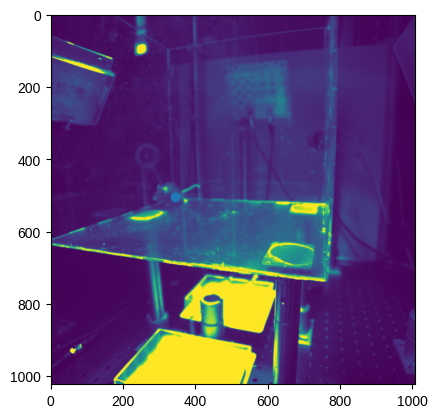

In [281]:
plt.imshow(all_labeled_frames_nomatch[152].image.squeeze())
for node, point in all_labeled_frames_nomatch[152].instances[0].points.items():
    plt.scatter(point.x, point.y)

In [282]:
params["directory_with_keypoint_data"] = kpoint_dir
params["version"] = use_version

In [285]:
save_dir = os.path.join(root_dir, "keypoints_basler_nir_plexiglass_arena/sleap_training_round2/_labels_qd/")
os.makedirs(save_dir, exist_ok=True)
embeds = [False]
save_prefix = os.path.splitext(save_fname)[0]
print(save_prefix)
print(len(all_labeled_frames_nomatch))

kpoint_training_dataset_qd_alignment_kneejoints_reflect_only_round2_manual_labeling_nofluo_version-v2
17901


In [286]:
filtered_qd_df.to_parquet(os.path.join(save_dir, f"{save_prefix}.parquet")) # save off the parquet file used to generate the data...

In [287]:
for embed in embeds:
    save_path = os.path.join(
        save_dir,
        f"{save_prefix}-embed-{embed}.slp",
    )
    labels = sio.Labels(labeled_frames=all_labeled_frames_nomatch)
    labels.save(save_path, embed=embed)
    with open(save_path.replace(".slp", ".toml"), "w") as f:
        toml.dump({"dataset_parameters": params, "frames": all_labeled_frames_metadata_nomatch}, f)

In [288]:
height, width = all_labeled_frames[0].image.squeeze().shape

In [289]:
use_cmap = plt.matplotlib.colormaps["turbo"]

In [290]:
movie_path = os.path.join(
    save_dir,
    f"{save_prefix}.mp4",
)

In [291]:
show_frames = 1000

In [292]:
new_frames = np.zeros((show_frames, height, width, 3), dtype="uint8")
spacing = np.floor(len(labels.labeled_frames) / len(new_frames))

In [293]:
nbody_parts = len(use_skeleton.nodes)
node_colors = {node: np.array(use_cmap(i / (nbody_parts - 1))[:3]) * 255 for i, node in enumerate(use_skeleton.nodes)}

In [294]:
vid_frame_idx = np.floor(np.linspace(0, len(labels.labeled_frames) - 1, show_frames)).astype("int")

In [295]:
for i, _idx in tqdm(enumerate(vid_frame_idx), total=len(vid_frame_idx)):
    _im = labels.labeled_frames[_idx].image.squeeze()
    use_im = np.round(np.stack([_im] * 3, axis=-1) * 0.75).astype("uint8")
    for node, point in labels.labeled_frames[_idx].instances[0].points.items():
        try:
            use_im = cv2.circle(use_im, (int(point.x), int(point.y)), 10, node_colors[node], -1)
        except ValueError:
            pass
    new_frames[i] = use_im

  0%|          | 0/1000 [00:00<?, ?it/s]

In [296]:
writer = vid.io.MP4WriterPreview(movie_path, frame_size = (width, height), fps=5)

In [297]:
writer.write_frames(new_frames, frames_idx=vid_frame_idx)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [298]:
writer.close()